In [1]:
from pathlib import Path
import sys

import pandas as pd
import numpy as np

from common_generate_predictions import (
    load_data,
    calculate_correlation,
    save_cv_results,
    save_correlation
)
from custom_types import Results
from cross_validation import cross_validation_for_dwug_es as cv

In [2]:
import seaborn as sns

In [3]:
def load_scores(llm: str, dataset: str, prompts: list, wic_data: bool = False):
    scores = {}

    for p in prompts:
        path_to_data = Path(f"{path_data}/{llm}/{dataset}/{p}")

        if wic_data is False:
            assert path_to_data.exists() is True, f"{path_to_data} does not exist"

        scores[p] = load_data(path_to_data, wic_data)

    return scores

# Wic2, DWUG_ES

In [4]:
lang = 'en'
data = load_data(f'../input/wic-scores/dwug_{lang}/wic2', wic_data=True)
# APD: average pairwise scores for each word, multiply by -1 to convert similarities to "distances"
pdf = -data.groupby('word').score.mean()
# pdf

2024-09-16 19:46:06,659 - INFO - loading data from ../input/wic-scores/dwug_en/wic2 ...


In [5]:
gdf = pd.read_csv(f'../test_data_{lang}.csv', sep='\t')
if 'word' not in gdf.columns:
    gdf['word']=gdf.lemma
gdf = gdf.set_index('word')
# gdf

In [7]:
gdf['pred'] = pdf

gdf[[c for c in gdf.columns if c in {'change_graded','COMPARE','pred'}]].corr(method='spearman')

,change_graded,pred
change_graded,1.000000,0.782381
pred,0.782381,1.000000


In [8]:
from scipy.stats import spearmanr
spr_lscd = spearmanr(gdf.pred, gdf.change_graded)[0]
print(spr_lscd)

0.7823807477118616


In [10]:
cv_words = sorted([x for l in cv[f'dwug_{lang}'][1].values() for x in l])
assert all(cv_words == sorted([x for l in cv[f'dwug_{lang}'][fold].values() for x in l]) for fold in range(2,6))
print(len(cv_words))
if sorted(gdf.index)!=cv_words:
    print('Words absent in CV:', set(gdf.index).difference(cv_words))
    print('Wrods absent  in the gold data:', set(cv_words).difference(gdf.index))

37
Words absent in CV: {'afternoon_nn', 'chef_nn', 'heel_nn', 'rally_nn', 'pick_vb', 'bar_nn', 'maxim_nn', 'grain_nn', 'include_vb'}
Wrods absent  in the gold data: set()


In [13]:
from scipy.stats import spearmanr
gdf1 = gdf[gdf.index.isin(cv_words)]
print(spearmanr(gdf.pred, gdf.change_graded)[0], spearmanr(gdf1.pred, gdf1.change_graded)[0])

0.7823807477118616 0.80768320980914


count    50000.000000
mean         0.750891
std          0.186824
min         -0.857143
25%          0.666667
50%          0.785714
75%          0.892857
max          1.000000
dtype: float64
count    10000.000000
mean         0.750891
std          0.061215
min          0.413392
25%          0.714286
50%          0.757143
75%          0.792857
max          0.924397
dtype: float64


<Axes: ylabel='Count'>

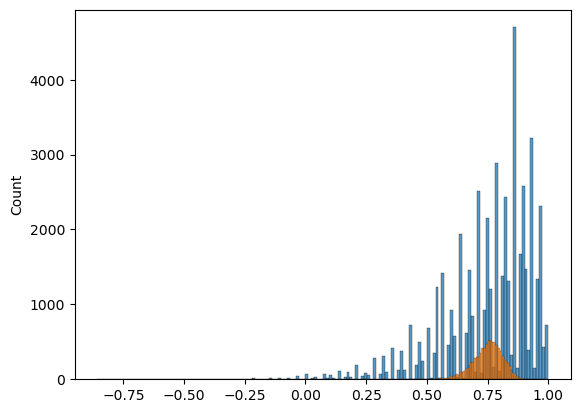

In [15]:
from sklearn.model_selection import KFold
def bootstrap_cvscores(correction_fun=None):
    scores, cv_scores = [], []
    for seed in range(10000):
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        fold_scores = []
        for i, (train_index, test_index) in enumerate(kf.split(cv_words)):
            test_words = [cv_words[i] for i in test_index]
            sample = gdf[gdf.index.isin(test_words)]
            spr_lscd = spearmanr(sample.pred, sample.change_graded)[0]
            if correction_fun:
                spr_lscd = correction_fun(spr_lscd, len(sample))
            fold_scores.append(spr_lscd)
        scores.extend(fold_scores)
        cv_scores.append(np.mean(fold_scores))
    print(pd.Series(scores).describe())
    print(pd.Series(cv_scores).describe())
    return scores, cv_scores

scores, cv_scores = bootstrap_cvscores()
sns.histplot(scores)
sns.histplot(cv_scores)


#### Spearman's correlation from 5-fold CV compared to the one on full dataset has:
bias: 0.592 vs. 0.624: can be corrected

variance: std: 0.05 => 95% CI is (0.5,0.7)

count    50000.000000
mean         0.780567
std          0.180897
min         -0.885569
25%          0.703704
50%          0.823296
75%          0.915492
max          1.000000
dtype: float64
count    10000.000000
mean         0.780567
std          0.060165
min          0.433086
25%          0.746642
50%          0.788015
75%          0.822441
max          0.939129
dtype: float64


<Axes: ylabel='Count'>

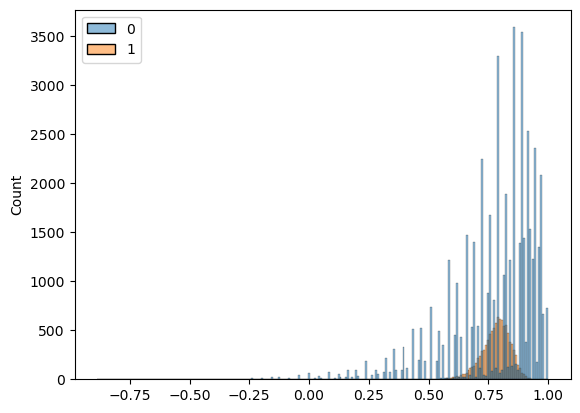

In [18]:
# Bias in estimation of correlation: https://www.uv.es/revispsi/articulos1.03/9.ZUMBO.pdf
def spearman_olkin_pratt_correction(r, n):
    return r * (1 + (1-r**2)/(2*(n-3)))

scores = bootstrap_cvscores(spearman_olkin_pratt_correction)
sns.histplot(scores)

In [19]:
spr_lscd = spearmanr(gdf.pred, gdf.change_graded)[0]
spr_corrected = spearman_olkin_pratt_correction(spr_lscd, len(gdf))
print(spr_lscd, spr_corrected)

0.7823807477118616 0.7859094701591705


# Check concrete folds

8
SignificanceResult(statistic=0.5000000000000001, pvalue=0.20703124999999997)


<Axes: xlabel='change_graded', ylabel='pred'>

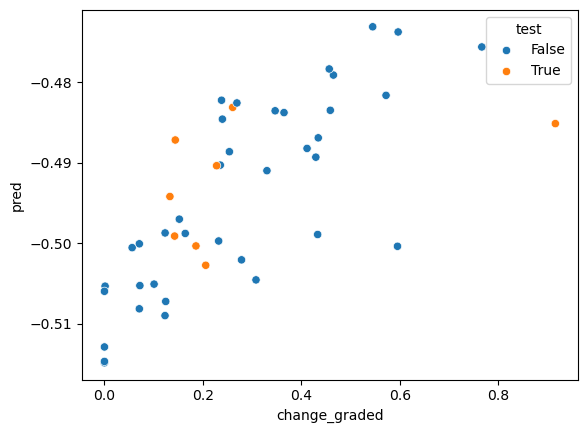

In [20]:
fold = 2
test_words = cv[f'dwug_{lang}'][fold]['test']

gdf['test'] = gdf.index.isin(test_words)
print(gdf['test'].sum())
print(spearmanr(gdf.query('test').change_graded, gdf.query('test').pred))
sns.scatterplot(data=gdf, x='change_graded', y='pred', hue='test')

In [84]:
sample.corr('spearman')

spr_lscd = spearmanr(sample.pred, sample.change_graded)[0]
spr_lscd

0.6881893469394459

In [18]:
sample

,lemma,grouping,nodes,nodes1,nodes2,cluster_freq_dist,cluster_freq_dist1,cluster_freq_dist2,cluster_prob_dist,cluster_prob_dist1,cluster_prob_dist2,change_binary,change_binary_gain,change_binary_loss,change_graded,k1,n1,k2,n2,pred
word,,,,,,,,,,,,,,,,,,,,
contemplation_nn,contemplation_nn,1_2,200,100,100,"[199, 1]","[99, 1]","[100, 0]","[0.995, 0.005]","[0.99, 0.01]","[1.0, 0.0]",0,0,0,0.070839,1,5,1,5,-0.511388
donkey_nn,donkey_nn,1_2,200,100,100,"[195, 1, 1]","[97, 1, 0]","[98, 0, 1]","[0.99, 0.005, 0.005]","[0.99, 0.01, 0.0]","[0.99, 0.0, 0.01]",0,0,0,0.100760,1,5,1,5,-0.518880
fiction_nn,fiction_nn,1_2,200,100,100,"[193, 1, 1, 1]","[95, 1, 1, 1]","[98, 0, 0, 0]","[0.985, 0.005, 0.005, 0.005]","[0.969, 0.01, 0.01, 0.01]","[1.0, 0.0, 0.0, 0.0]",0,0,0,0.124410,1,5,1,5,-0.518352
ounce_nn,ounce_nn,1_2,200,100,100,"[196, 1, 1, 1]","[97, 1, 1, 0]","[99, 0, 0, 1]","[0.985, 0.005, 0.005, 0.005]","[0.98, 0.01, 0.01, 0.0]","[0.99, 0.0, 0.0, 0.01]",0,0,0,0.122964,1,5,1,5,-0.512877
rag_nn,rag_nn,1_2,200,100,100,"[156, 9, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1]","[84, 7, 2, 2, 0, 1, 1, 1, 0, 0, 0, 0]","[72, 2, 4, 3, 2, 0, 0, 0, 1, 1, 1, 1]","[0.843, 0.049, 0.032, 0.027, 0.011, 0.005, 0.0...","[0.857, 0.071, 0.02, 0.02, 0.0, 0.01, 0.01, 0....","[0.828, 0.023, 0.046, 0.034, 0.023, 0.0, 0.0, ...",0,0,0,0.253659,1,5,1,5,-0.484325
risk_nn,risk_nn,1_2,200,100,100,[200],[100],[100],[1.0],[1.0],[1.0],0,0,0,0.000000,1,5,1,5,-0.514487
savage_nn,savage_nn,1_2,200,100,100,"[196, 1]","[100, 0]","[96, 1]","[0.995, 0.005]","[1.0, 0.0]","[0.99, 0.01]",0,0,0,0.071930,1,5,1,5,-0.506013
